In [1]:
import numpy as np 
import matplotlib.pylab as plt
from getdist import plots, MCSamples
import getdist
import pandas as pd
import sys
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# our script
import utils.helpers as hp

fontSize = 20

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
np.set_printoptions(precision=3)

# boot means bootstrap below, that is, random samples of n(z)

## George $n(z)$ Samples

In [2]:
mean_bayes = hp.load_pkl_file('samples', 'Samples_Bayes_15000_18_emulator_DS_mean_nz')
boot_bayes = hp.load_pkl_file('samples', 'Samples_Bayes_15000_18_emulator_DS_bootstrap_nz')

In [3]:
mean_samples = mean_bayes.flatchain
boot_samples = boot_bayes.flatchain

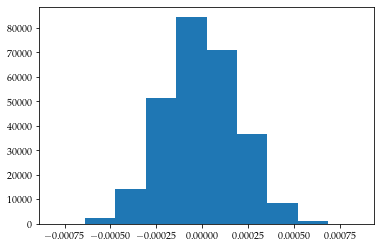

In [41]:
plt.figure()
plt.hist(10**-4 * mean_samples[:,-3])
plt.show()

In [35]:
np.median(mean_samples, axis = 0)

array([ 0.139,  2.555,  0.022,  1.056,  0.736, -0.787, -0.102,  1.031,
        1.204])

In [4]:
mean_samples[:,-3] *= 1E4 
boot_samples[:,-3] *= 1E4 

In [5]:
labels = [r'$\Omega_{\textrm{cdm}}h^{2}$',
          r'$\textrm{ln}10^{10}A_{s}$',
          r'$\Omega_{\textrm{b}}h^{2}$',
          r'$n_{s}$',
          r'$h$',
          r'$A_{\textrm{IA}}$', 
          r'$10^{4}\,\delta c$', 
          r'$A_{c}$',
          r'$A_{\textrm{bary}}$']

ndim = len(labels)
names = ["x%s"%i for i in range(ndim)]

label_mean = 'Mean of $n(z)$'
label_boot = 'A Sample of $n(z)$'

samples_mean = MCSamples(samples=mean_samples,names = names, labels = labels, settings = settings, label=label_mean)
samples_boot = MCSamples(samples=boot_samples,names = names, labels = labels, settings = settings, label=label_boot)

Removed no burn in
Removed no burn in


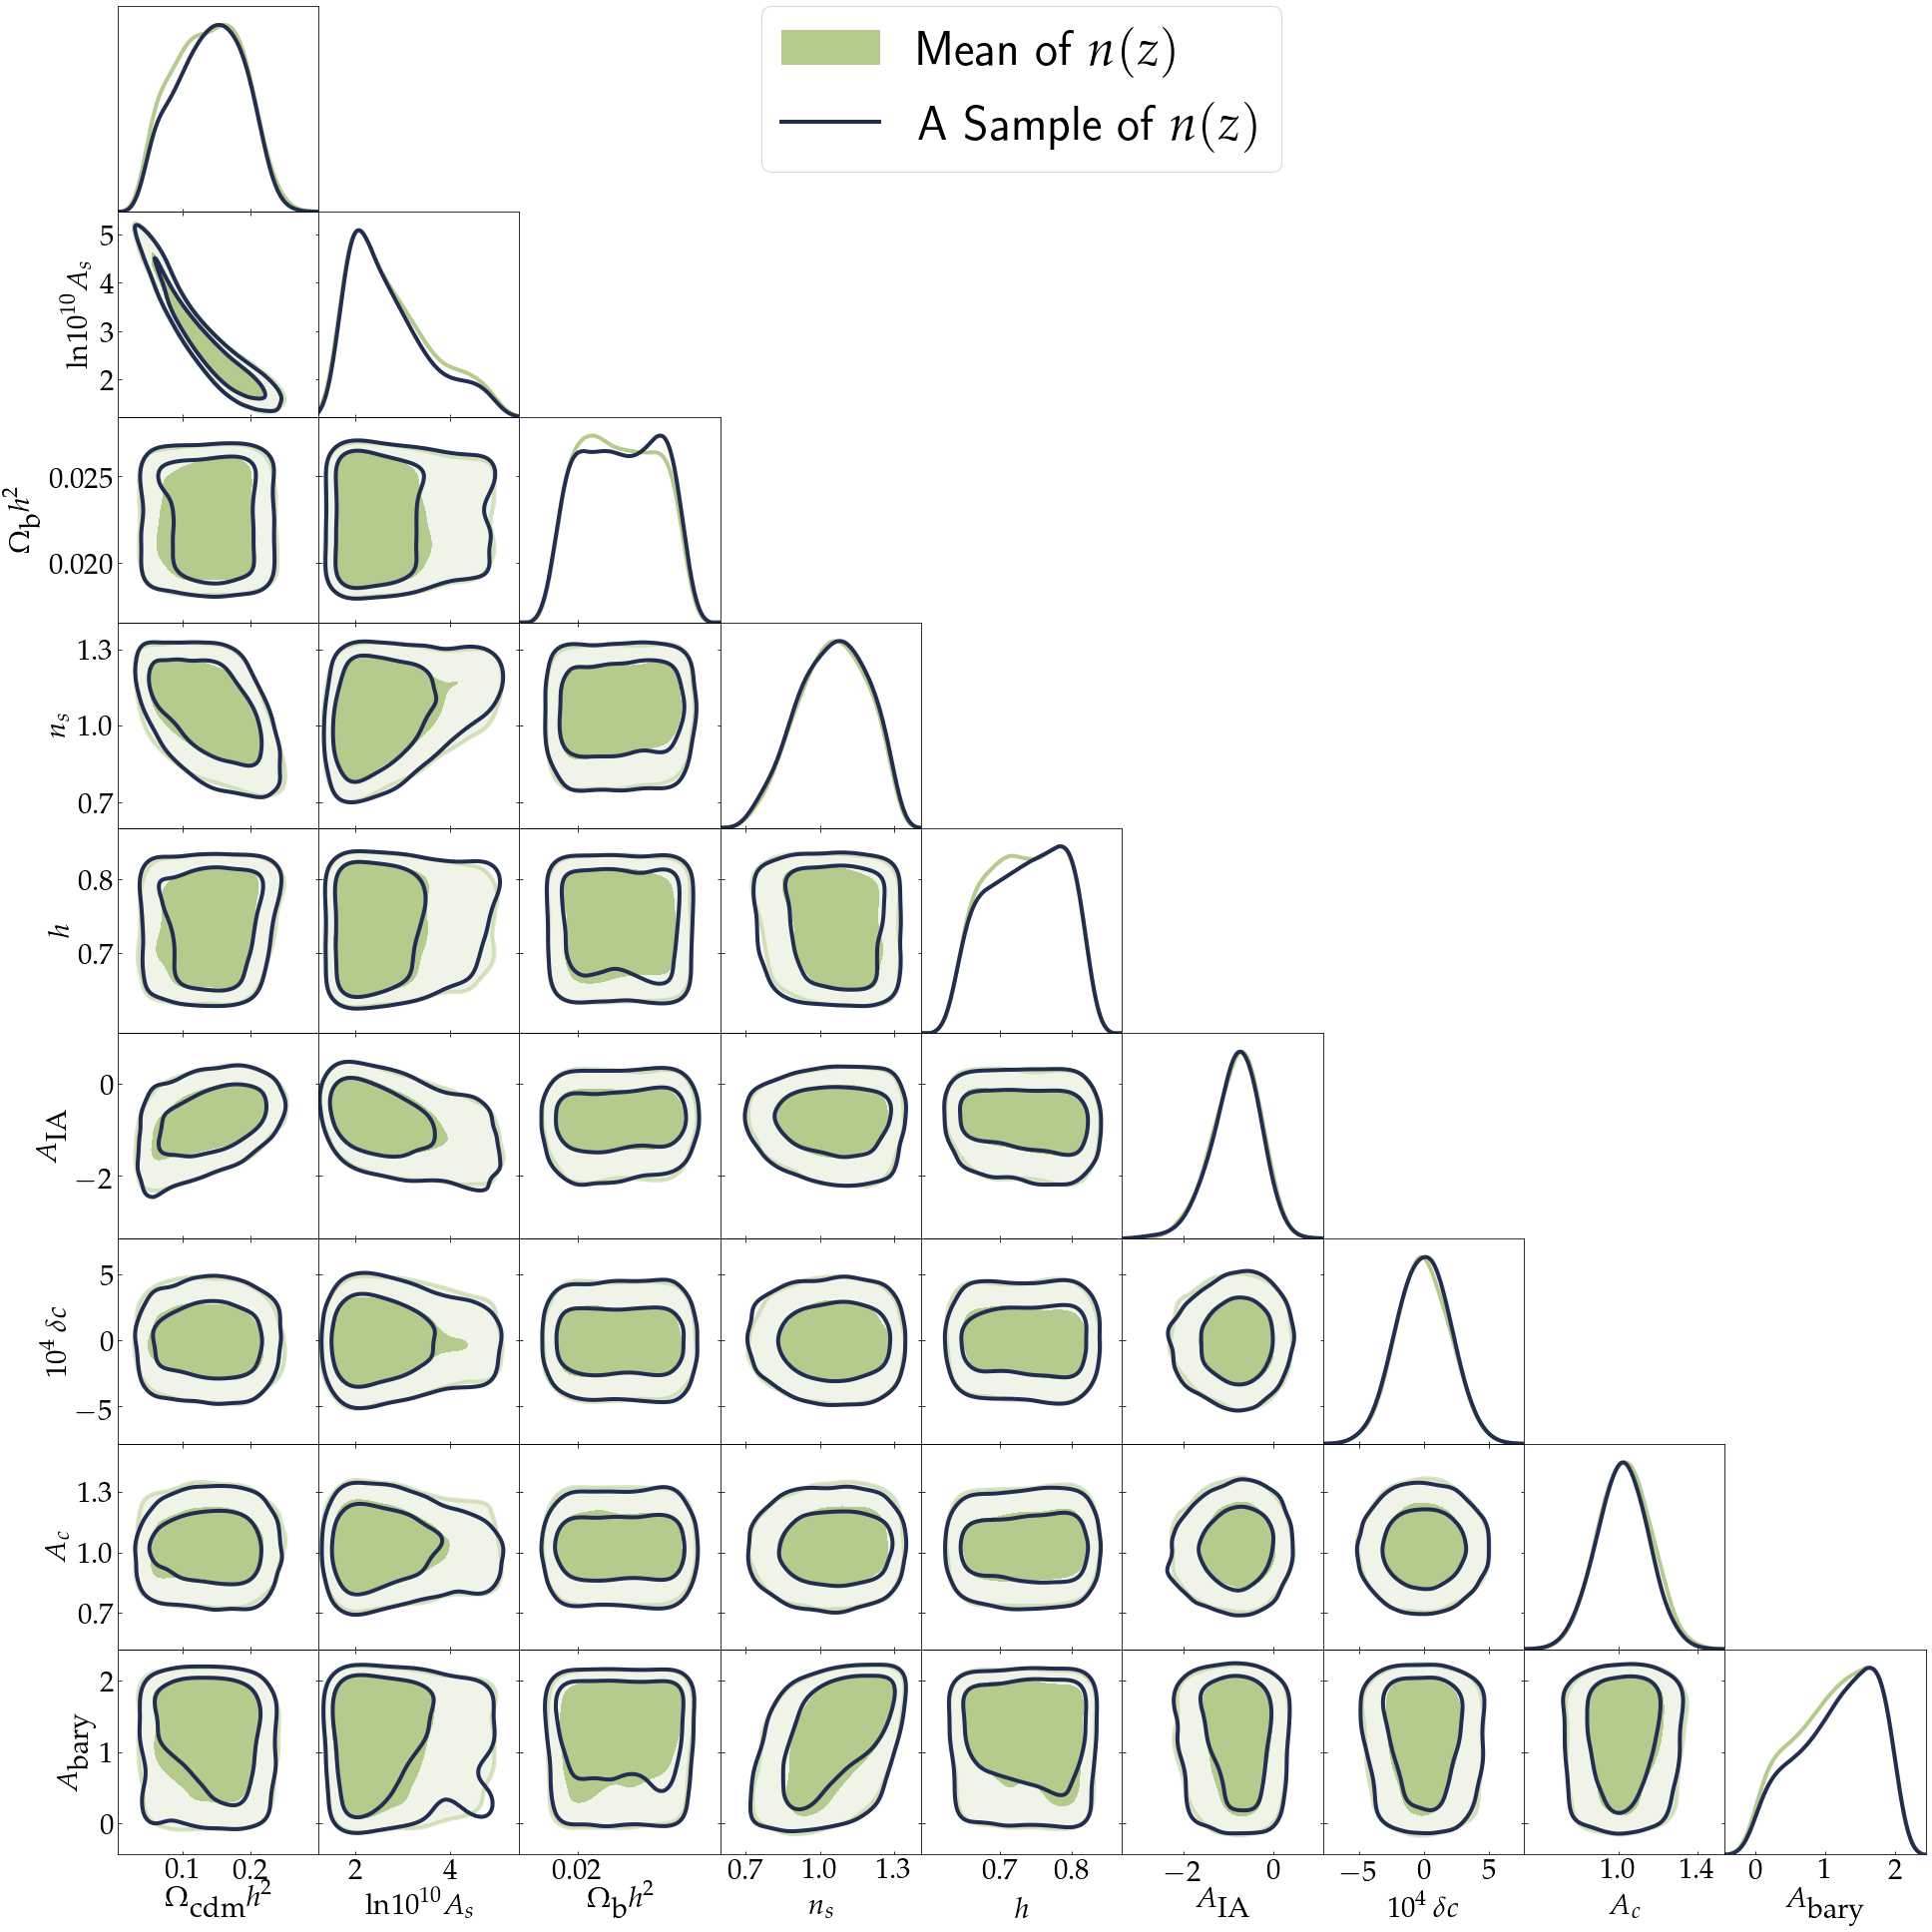

In [6]:
c1 = '#B5CA8D'
c3 = '#222E50'
alpha = 0.7
contours = np.array([0.68,0.95])

G = plots.getSubplotPlotter(subplot_size=3)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 5
G.settings.axes_fontsize = 30
G.settings.lab_fontsize = 30
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 50
samples_mean.updateSettings({'contours': [0.68, 0.95]})
samples_boot.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples_mean, samples_boot], filled = [True,False], contour_colors=[c1, c3], contour_lws=[4,4], contour_ls=['-', '-'])
plt.savefig('plots/emulator_distribution_5.pdf', transparent = False, bbox_inches = 'tight') 
plt.show()

### Model to predict $\sigma_{8}$

In [7]:
import ml.zerogp as zgp
import utils.helpers as hp
import numpy as np

In [8]:
inputs = hp.load_arrays('sigmaEight', 'cosmologies')
outputs = hp.load_arrays('sigmaEight', 'sigma_8')

In [9]:
Nrestart    = 2
Ndim        = 5
bounds      = np.repeat(np.array([[-1.5,6]]), Ndim+1, axis = 0)
bounds[0] = np.array([-5, 5])

In [10]:
gp_module = zgp.GP(inputs, outputs, 1E-6, True, False, False)

In [11]:
gp_module.do_transformation()

In [12]:
hyperparameters = gp_module.fit(method = 'L-BFGS-B', bounds = bounds, 
              options = {'ftol':1E-12, 'maxiter':500}, n_restart=Nrestart)

[-5163.508 -5163.508]


In [13]:
testpoint = np.array([0.12, 3.45, 0.0225, 1.0, 0.72])

In [14]:
gp_module.prediction(testpoint)

array([1.021])

### Calculate $\sigma_{8}$ for all MCMC samples

In [15]:
mean_cosmologies = mean_samples[:,0:5]
boot_cosmologies = boot_samples[:,0:5]

In [16]:
nsamples = mean_cosmologies.shape[0]

In [17]:
sigma_8_mean = np.array([gp_module.prediction(mean_cosmologies[i]) for i in range(nsamples)])
sigma_8_boot = np.array([gp_module.prediction(boot_cosmologies[i]) for i in range(nsamples)])

In [18]:
sigma_8_mean = sigma_8_mean.flatten()
sigma_8_boot = sigma_8_boot.flatten()

### Calculate $\Omega_{\textrm{m}}$

In [19]:
omega_matter_mean = (mean_cosmologies[:,0] + mean_cosmologies[:,2])/mean_cosmologies[:,4]**2
omega_matter_boot = (boot_cosmologies[:,0] + boot_cosmologies[:,2])/boot_cosmologies[:,4]**2

### 2D Plot for $\sigma_{8}$ versus $\Omega_{\textrm{m}}$

In [20]:
sigma_8_om_mean = np.concatenate((omega_matter_mean.reshape(nsamples, 1), sigma_8_mean.reshape(nsamples, 1)), axis = 1)
sigma_8_om_boot = np.concatenate((omega_matter_boot.reshape(nsamples, 1), sigma_8_boot.reshape(nsamples, 1)), axis = 1)

In [21]:
# number of dimensions for plotting
ndim = 2

# some names for the parameters
names = ["x%s"%i for i in range(ndim)]
labels = [r'$\Omega_{\textrm{m}}$', r'$\sigma_{8}$']


mean_plot_sig = MCSamples(samples=sigma_8_om_mean,names = names, labels = labels, settings = settings)
boot_plot_sig = MCSamples(samples=sigma_8_om_boot,names = names, labels = labels, settings = settings)

Removed no burn in
Removed no burn in


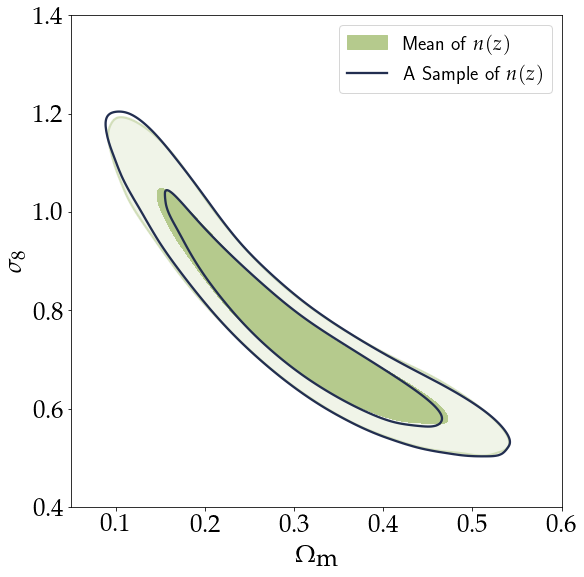

In [22]:
G = plots.getSinglePlotter(width_inch=8, ratio=1)
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 25
G.settings.lab_fontsize = 25
G.settings.fontsize = 25 # important for padding in x-axis 
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.legend_fontsize = 20
mean_plot_sig.updateSettings({'contours': [0.68, 0.95]})
boot_plot_sig.updateSettings({'contours': [0.68, 0.95]})
G.plot_2d([mean_plot_sig, boot_plot_sig], 'x0', 'x1', filled=[True, False], colors=['#B5CA8D', '#222E50'])
G.add_legend([label_mean, label_boot], legend_loc='upper right');
plt.xlim(0.05, 0.60)
plt.ylim(0.40, 1.40)
plt.savefig('plots/sigma_8_Omega_Matter.pdf', transparent = False, bbox_inches = 'tight') 
plt.show()

### Calculate $S_{8}$

$$
S_{8}\equiv\sigma_{8}\sqrt{\frac{\Omega_{\textrm{m}}}{0.3}}
$$

In [23]:
S_8_mean = sigma_8_mean * np.sqrt(omega_matter_mean/0.3)
S_8_boot = sigma_8_boot * np.sqrt(omega_matter_boot/0.3)

### Concatenate Samples

In [24]:
samples_2d_mean = np.concatenate((omega_matter_mean.reshape(nsamples, 1), S_8_mean.reshape(nsamples, 1)), axis = 1)
samples_2d_boot = np.concatenate((omega_matter_boot.reshape(nsamples, 1), S_8_boot.reshape(nsamples, 1)), axis = 1)

### Load Planck Chain

In [25]:
folder = '/home/harry/Desktop/Planck/base/plikHM_TTTEEE_lowl_lowE/'

c1 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_1.txt')
c2 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_2.txt')
c3 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_3.txt')
c4 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_4.txt')

s1 = np.array([c1[:,31], c1[:,36]]).T
s2 = np.array([c2[:,31], c2[:,36]]).T
s3 = np.array([c3[:,31], c3[:,36]]).T
s4 = np.array([c4[:,31], c4[:,36]]).T

samples_planck = np.concatenate([s1, s2, s3, s4])

### 2D Plot

In [26]:
# number of dimensions for plotting
ndim = 2

# some names for the parameters
names = ["x%s"%i for i in range(ndim)]
labels = [r'$\Omega_{\textrm{m}}$', r'$S_{8}$']


mean_plot = MCSamples(samples=samples_2d_mean,names = names, labels = labels, settings = settings)
boot_plot = MCSamples(samples=samples_2d_boot,names = names, labels = labels, settings = settings)
plan_plot = MCSamples(samples=samples_planck,names = names, labels = labels, settings = settings)

Removed no burn in
Removed no burn in
Removed no burn in


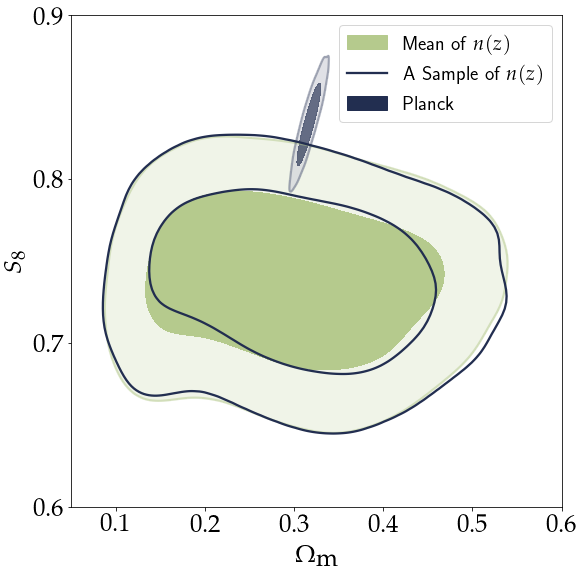

In [27]:
G = plots.getSinglePlotter(width_inch=8, ratio=1)
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 25
G.settings.lab_fontsize = 25
G.settings.fontsize = 25 # important for padding in x-axis 
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.legend_fontsize = 20
mean_plot.updateSettings({'contours': [0.68, 0.95]})
boot_plot.updateSettings({'contours': [0.68, 0.95]})
G.plot_2d([mean_plot, boot_plot, plan_plot], 'x0', 'x1', filled=[True, False, True], colors=['#B5CA8D', '#222E50', '#222E50'])
G.add_legend([label_mean, label_boot, 'Planck'], legend_loc='upper right');
plt.xlim(0.05, 0.60)
plt.ylim(0.60, 0.90)
plt.savefig('plots/S8_Omega_Matter_Planck.pdf', transparent = False, bbox_inches = 'tight') 
plt.show()

# Results

### Mean of $n(z)$

In [28]:
np.mean(samples_2d_mean, axis = 0)

array([0.3  , 0.738])

In [29]:
np.percentile(samples_2d_mean,[16,84],axis=0) - np.mean(samples_2d_mean, axis = 0)

array([[-0.108, -0.036],
       [ 0.104,  0.035]])

### Samples of $n(z)$

In [30]:
np.mean(samples_2d_boot, axis = 0)

array([0.304, 0.738])

In [31]:
np.percentile(samples_2d_boot,[16,84],axis=0) - np.mean(samples_2d_boot, axis = 0)

array([[-0.104, -0.036],
       [ 0.097,  0.035]])

### Tension $S_{8}$

In [32]:
(0.834 - np.mean(samples_2d_mean, axis = 0)[1])/np.std(samples_2d_mean, axis = 0)[1]

2.6677874756940705

In [33]:
(0.834 - np.mean(samples_2d_boot, axis = 0)[1])/np.std(samples_2d_mean, axis = 0)[1]

2.6651785434213995